In [168]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

In [239]:
data = pd.read_csv('train_mnist.csv')
n = data.shape[0]
train_df = data.iloc[:int(n*0.8), :]
test_df = data.iloc[int(n*0.8):, :]



# Análisis Exploratorio de Datos

<BarContainer object of 10 artists>

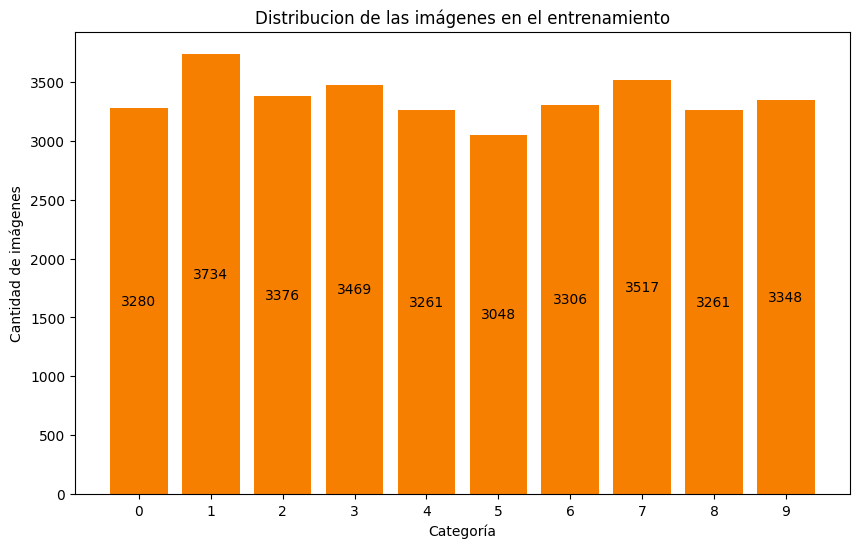

In [186]:
s = pd.Series(train_df['label'], dtype="category")
categories = np.array(s.cat.categories)
counts = np.array(s.value_counts(sort=False))
bar_labels = [str(i) for i in categories]
plt.bar_label(plt.bar(bar_labels, counts, color='#f77f00'), label_type='center')
plt.title('Distribucion de las imágenes en el entrenamiento')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de imágenes')
plt.bar(bar_labels, counts, label=bar_labels, color='#f77f00')


Se puede observar que las categorías no están balanceadas. La categoría 1 tiene más observaciones que las demás (`3734`). A continuación observamos un ejemplo de cada imágen:

In [240]:
samples = []
for i in range(10):
		sample = (train_df.loc[train_df['label'] == i])[:1]
		# Drop the label column
		sample = sample.drop(labels = ['label'],axis = 1)
		# Convert the dataframe to a numpy array
		# sample =[(v,v,v) for v in np.array(sample)]
		sample = np.array(sample)
		# Reshape the array into 28 x 28 array (2-dimensional array)
		sample = sample.reshape(28, 28)
		sample = sample.astype('uint8')
		samples.append(sample)

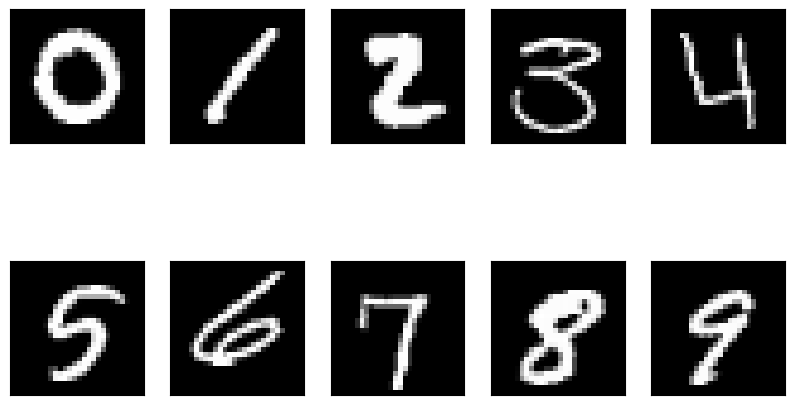

In [241]:

fig, ax = plt.subplots(2,5)
for axi in ax.flat:
		axi.xaxis.set_visible(False)
		axi.yaxis.set_visible(False)

for i in range(2):
	for j in range(5):
		image = samples[i*5+j]
		ax[i,j].imshow(image, cmap='gray')

# Utilizando Modelos 

In [268]:
train_df = data.iloc[:int(n*0.8), :]
test_df = data.iloc[int(n*0.8):, :]
y = train_df['label']
train_df = train_df.drop(['label'], axis=1)
X_train = train_df

y_test = test_df['label']
test_df = test_df.drop(['label'], axis=1)
X_test = test_df

### Red Neuronal Simple

In [269]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing



In [270]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [288]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,3,9), random_state=1, max_iter=1000)
clf.fit(np.array(X_train_scaled), np.array(y))


/Users/guillermosantosbarrios/Developer/Universidad/2023/Data Science/uvg_data_science_lab_3/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 3, 9), max_iter=1000,
              random_state=1, solver='lbfgs')

In [290]:
X_test_scaled = scaler.transform(X_test)
predictions = clf.predict(X_test_scaled)

A continuación se verifica la calidad del modelo prediciendo

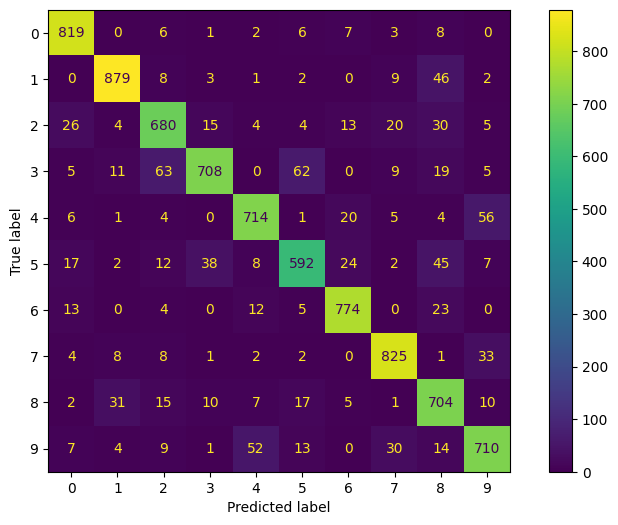

In [291]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()


In [293]:
accuracy_score(y_test, predictions, normalize=True)

0.881547619047619

El accuracy para el modelo es de `0.8815`